In [2]:
# Operating System Interaction
import os # to interact with the operating system
import glob # to find files in directories

# Numerical and Data Handling
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import xarray as xr # for n-dimensional data manipulation

# Data Interpolation and Signal Processing
from scipy.interpolate import griddata # for data interpolation
from scipy import signal # for signal processing
import scipy.fftpack as fp # for fast fourier transforms

# Convolution Operations
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans # for convolution operations

# Plotting and Visualization 
import matplotlib.pyplot as plt # for plotting
import cartopy.crs as ccrs # for cartographic projections
import cartopy.feature as cfeature # for cartographic features
import cartopy # for cartographic projections

# Scientific Computing and Evaluation
import xskillscore # for model evaluation

# System and Performance Management
import sys # for system management
import gc # for garbage collection

# Parallel Computing (Commented Out)
#from dask import delayed, compute

# Loading Data

In [3]:
dir_input = '/bettik/bellemva/MITgcm/MITgcm_filtered_final'
pattern = 'MITgcm_filt_'
start_date = 20120401
end_date = 20120402

# Generate the full pattern to match files
full_pattern = os.path.join(dir_input, f"{pattern}*.nc")

# List all files that match the basic pattern
all_files = glob.glob(full_pattern)

# Filter files by date range
filtered_files = [file for file in all_files if start_date <= int(os.path.basename(file).split('_')[-1].split('.')[0]) <= end_date]

# Open the dataset
ds_ssh = xr.open_mfdataset(filtered_files, parallel=True)

In [3]:
ds_ssh

<xarray.Dataset> Size: 68GB
Dimensions:    (time: 360, latitude: 1681, longitude: 3121)
Coordinates:
  * time       (time) datetime64[ns] 3kB 2012-04-01 ... 2012-04-15T23:00:00
  * latitude   (latitude) float64 13kB 10.0 10.02 10.04 ... 44.96 44.98 45.0
  * longitude  (longitude) float64 25kB 180.0 180.0 180.0 ... 245.0 245.0 245.0
Data variables:
    ssh_bar    (time, latitude, longitude) float64 15GB dask.array<chunksize=(49, 1681, 3121), meta=np.ndarray>
    mask       (time, latitude, longitude) float64 15GB dask.array<chunksize=(24, 1681, 3121), meta=np.ndarray>
    ssh_hf     (time, latitude, longitude) float64 15GB dask.array<chunksize=(3, 241, 446), meta=np.ndarray>
    ssh_dedac  (time, latitude, longitude) float32 8GB dask.array<chunksize=(4, 337, 625), meta=np.ndarray>
    ssh_bm     (time, latitude, longitude) float64 15GB dask.array<chunksize=(3, 241, 446), meta=np.ndarray>
Attributes:
    NCO:      netCDF Operators version 4.9.8 (Homepage = http://nco.sf.net, C...

In [4]:
ds_ssh = ds_ssh.chunk({'longitude':5*48,'latitude':5*48,'time':ds_ssh.time.size})

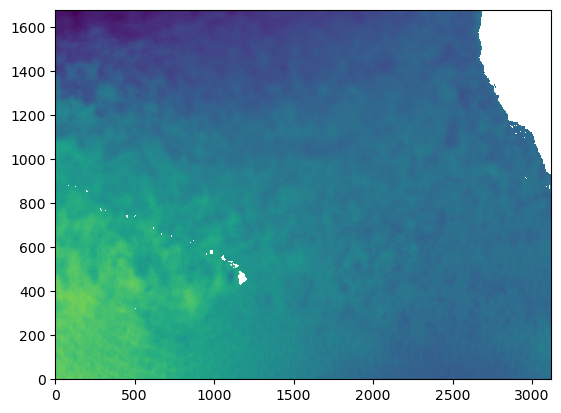

In [5]:
plt.pcolormesh(ds_ssh.ssh_dedac[0,:,:])

# Calculating HF and BM

Some acronyms: HF : High Frequency, BM : Balanced Motions, BAR : Barotropic Tide, IGW : Internal Gravity Waves, and IT : Internal Tide.

In [4]:
# Setting some variables

longitude = ds_ssh.longitude.values
latitude = ds_ssh.latitude.values
time = ds_ssh.time.values
nt = time.size
ny = latitude.size
nx = longitude.size

## Coriolis period

### Coriolis Period

This equation gives the period of a pendulum oscillating freely under the influence of the Coriolis force at the given latitude.

$$T = \frac{2\pi}{f}$$

### Coriolis Parameter

The Coriolis parameter, by $f$, is a factor that **describes** the effect of the Earth's rotation **on moving objects**. It is defined as:

$$ f = 2 \Omega \sin(\phi) $$

where:

- $\Omega$ is the angular velocity of the Earth's rotation (~7.292E-5 [rad/s] which is calculated from 2$\pi$ over 86164 which is the time of a sideral year in seconds.)
- $\phi$ is the latitude of the location in question.

The Coriolis parameter varies with latitude, affecting the movement of objects differently depending on their location on the Earth's surface. It's zero at the Equator and increases/decreases in magnitude toward the poles. 

In [5]:
# Coriolis period
f = 2*(2*np.pi/86164)*np.sin(np.mean(np.deg2rad(latitude))) 
T = np.abs(2*np.pi/f) # Including absolut becase the periode has to be positive

In [7]:
f

6.734255650083778e-05

In [29]:
T//2

46650.0

In [8]:
2*T/3600

51.834361291869456

In [9]:
dt = 3600 # number of seconds in a hour 
window_len = int(2*T//dt) # length of the gaussian filter window 
time_window = np.arange(-window_len,window_len+1) # array time steps to compute the kernel 
exp_window = np.exp(-np.square(time_window/(T/dt))) # array of kernel values 
ntw = time_window.size

In [24]:
ssh_dedac

<xarray.DataArray 'ssh_dedac' (time: 360, latitude: 1681, longitude: 3121)> Size: 8GB
dask.array<rechunk-merge, shape=(360, 1681, 3121), dtype=float32, chunksize=(360, 240, 240), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 3kB 2012-04-01 ... 2012-04-15T23:00:00
  * latitude   (latitude) float64 13kB 10.0 10.02 10.04 ... 44.96 44.98 45.0
  * longitude  (longitude) float64 25kB 180.0 180.0 180.0 ... 245.0 245.0 245.0

In [14]:
weight = xr.DataArray(exp_window, dims=['window'])
ssh_dedac = ds_ssh.ssh_dedac.chunk({'longitude':5*48,'latitude':5*48,'time':ds_ssh.time.size})#[:nt-nt%ntw]


In [25]:
ssh_bm = ssh_dedac.rolling(time=ntw, center=False).construct('window').dot(weight)/weight.sum()

In [26]:
ssh_bm[0,:,:].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
ssh_bm = ssh_bm.chunk({'longitude':5*48,'latitude':5*48,'time':-1})

#ssh_hf = ssh_dedac - ssh_bm
#ssh_hf = ssh_hf.chunk({'longitude':5*48,'latitude':5*48,'time':ssh_dedac.time.size})

In [13]:
ssh_dedac[0,:,:].values

array([[ 1.2135515 ,  1.2135515 ,  1.205739  , ...,  0.47385   ,
         0.47385   ,  0.47385   ],
       [ 1.2086687 ,  1.2086687 ,  1.205739  , ...,  0.4718969 ,
         0.4718969 ,  0.48263907],
       [ 1.2086687 ,  1.2086687 ,  1.2086687 , ...,  0.4718969 ,
         0.4718969 ,  0.49045157],
       ...,
       [-0.18050468, -0.18050468, -0.17562187, ...,         nan,
                nan,         nan],
       [-0.18050468, -0.18050468, -0.17659843, ...,         nan,
                nan,         nan],
       [-0.18050468, -0.18050468, -0.17757499, ...,         nan,
                nan,         nan]], dtype=float32)

In [27]:
ssh_bm[0,:,:].values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [ ]:
lat0 = 25

In [ ]:
def save_bm_hf(_ssh_dedac,_ssh_bm,dir_output):
    _ssh_bm = _ssh_bm.load()
    _ssh_hf = _ssh_dedac - _ssh_bm

    dsout = xr.Dataset({'ssh_dedac':(('time','latitude','longitude'),_ssh_dedac.data),
                    'ssh_bm':(('time','latitude','longitude'),_ssh_bm.data),
                    'ssh_hf':(('time','latitude','longitude'),_ssh_hf.data)
                    },
                    coords={'time':('time',_ssh_dedac.time.values),'latitude':('latitude',_ssh_dedac.latitude.values),'longitude':('longitude',_ssh_dedac.longitude.values)}
                    )

    name_file = "MITgcm_filt_"+str(_ssh_dedac.latitude.values[0])+"_"+str(_ssh_dedac.longitude.values[0])+".nc"

    dsout.to_netcdf(os.path.join(dir_output,name_file))

    del _ssh_dedac, _ssh_bm 
    gc.collect()

dir_output = "/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Varios"

delayed_results = []
for lon in np.arange(180rhdrhet,245,5):
    
    save_bm_hf(ssh_dedac.sel(latitude = slice(lat0,lat0+5),longitude = slice(lon,lon+5)),
               ssh_bm.sel(latitude = slice(lat0,lat0+5),longitude = slice(lon,lon+5)),
               dir_output)

    print( lat0, " ; ", lon, " : done " )

print("separation hf bm ok \n \n")

In [ ]:
test = xr.open_mfdataset('/bettik/PROJECTS/pr-data-ocean/riverama/Datos/Varios/MITgcm_filt_25.0_180.0.nc')

In [ ]:
test

In [ ]:
# Selecting the first time point and the 'ssh_dedac' variable
first_time_ssh_dedac = test['ssh_bm'].isel(time=0)

# Plotting
plt.figure(figsize=(10, 6))
first_time_ssh_dedac.plot(x='longitude', y='latitude', cmap='viridis')
plt.title('Sea Surface Height (ssh_dedac) for the First Time Point')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()